In [1]:
%pylab inline
import ltdatas
import fitit

Populating the interactive namespace from numpy and matplotlib


In [2]:
import importlib
importlib.reload(ltdatas)

<module 'ltdatas' from '/srv/share/callum/2019 Fridge/fork fitting/ltdatas.py'>

In [68]:
fname_psd = "../../../Fridge/2019_Helmholtz/ProcessedData Feb12/Cool Feb13 0115 Feb13 0730 10x PSD.npy"
fname_fs = "../../../Fridge/2019_Helmholtz/ProcessedData Feb12/Cool Feb13 0115 Feb13 0730 10x frequencies.npy"
hhdata = load(fname_psd, mmap_mode='r')
fs = load(fname_fs)
hhdata.shape, fs.shape

DF = mean(fs[1:] - fs[:-1])

(100, 200)

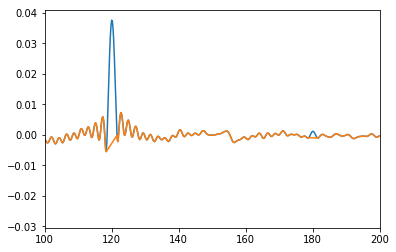

In [175]:
N = 320

figure()

fmask60Hz = ones_like(fs, dtype=bool)

for i in range(2, 10):
    fmask60Hz[abs(fs - 60*i) <= 1.5] = False


plot(fs, hhdata[N])
plot(fs[fmask60Hz], hhdata[N][fmask60Hz])
xlim(100, 200)

In [43]:
df

0.2

(100, 200)

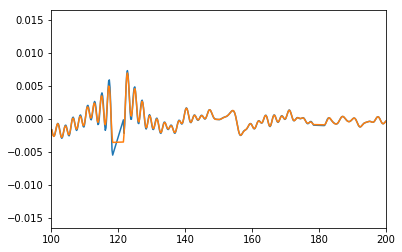

In [54]:
import scipy.signal as sig


b, a = sig.butter(8, 2.*df / 2)

filtered = sig.filtfilt(b, a, hhdata[N][fmask])

figure()

plot( fs[fmask], hhdata[N][fmask])
plot( fs[fmask], filtered)

xlim(100, 200)

In [6]:

fano_params = fitit.Params("bg0 *bg1 A f0 gamma *fano")
fano_params.bg0 = 0
fano_params.bg1 = 0
fano_params.A = .1
fano_params.f0 = 1200
fano_params.gamma = 10
fano_params.fano = 1.

def fano(x,p) :
    e = 2. * (p.f0 - x) / p.gamma
    return p.A * (e + p.fano)**2. / (e**2. + 1.) + p.bg0 + (x - p.f0)*p.bg1

In [186]:



class HHData(ltdatas.LTData):
    def __init__(self, iden, dataset, **kwargs):
        ltdatas.LTData.__init__(self, iden, dataset)
        self._stored = ['iden', 'p0', 'popt', 'fit_status']
        
        self.i = iden
        self.p0 = kwargs.pop('p0', None)
        self.popt = kwargs.pop('popt', None)
        self.fit_status = kwargs.pop('fit_status', 0)
        
        # iden is index into hhdata
        
    def fitold(self, do_plot=False):
        if self.p0 is None:
            self.p0 = self.last().popt
        
        self.popt = fitit.fit(fano, fs, hhdata[self.i], p0=self.p0)
        self.popt.fitinfo = None # old versions of fitinfo would store this. remove so saved files are smaller.
        self.fit_status = 10
        
        if do_plot:
            self.plot()
            
        return self.fit_status
        # iden is index into hhdata
        
    def guess_p0(self):
        pn1 = self.last().popt
        pn2 = self.last().last().popt
        
        p = fitit.Params(like=pn1)
        p.f0 =  2.*pn1.f0 - pn2.f0
        
        return p
        
    def fit(self, do_plot=False):
        if self.p0 is None:
            self.p0 = self.last().popt
            
        f, y = self.getnearsig(self.p0.f0, abs(self.p0.gamma), ndf=5, filt=0)
        sig = abs(f - self.p0.f0)
        
        self.popt = fitit.fit(fano, f, y, p0=self.p0, sig=sig)
        self.popt.fitinfo = None # old versions of fitinfo would store this. remove so saved files are smaller.
        self.fit_status = 10
        
        this = r_[self.popt.gamma, self.popt.f0]
        last = r_[self.p0.gamma, self.p0.f0]
        change = abs((this - last)/last)
        if any(change > .3):
            print("changed too quickly!")
            print(change)
            self.popt = self.p0
        
        
        if do_plot:
            self.plot()
            
        return self.fit_status
    
    def getnearsig(self, f0, df, ndf=5, filt=0):
        fmask = abs(fs - f0) < abs(ndf*df)
        fmask = fmask & fmask60Hz

        if filt > 2.*DF:
            cutoff = 2.*DF / filt
            b, a = sig.butter(6, cutoff)
            fmask2 = abs(fs - f0) < (ndf + 1)*df
            x = hhdata[self.i][fmask2]
            y = sig.filtfilt(b, a, x)
            
            Y = y[fmask[fmask2]]
        else:
            Y = hhdata[self.i][fmask]

        return fs[fmask], Y
        
        
        
            
    def __repr__(self):
        return "%s %d" % (str(self.iden), self.fit_status)
        
        
#     def plot(self):
#         self.fig = figure()
        
#         plot(fs, hhdata[self.i])
        
#         if self.p0 is not None:
#             plot(fs, fano(fs, self.p0), 'k--', label='p0')
            
#         if self.popt is not None:
#             plot(fs, fano(fs, self.popt), '-', label='popt')
        
#         xlabel("Frequency (Hz)")
#         ylabel("PSD (AU)")
        
    def plot(self, filt=0):
        self.fig2 = figure()
        
        fs, y = self.getnearsig(self.p0.f0, self.p0.gamma, ndf=10, filt=filt)
        
        plot(fs, y, '.')
        
        if self.p0 is not None:
            plot(fs, fano(fs, self.p0), 'k--', label='p0')
            
        if self.popt is not None:
            plot(fs, fano(fs, self.popt), '-', label='popt')
        
        xlabel("Frequency (Hz)")
        ylabel("PSD (AU)")
        
        
        
        
    def close_plot(self):
        try:
            self.fig.close()
        except NameError:
            pass

hhdatas.upgrade_model(HHData)
        
# hhdatas = ltdatas.LTDataSet(HHData)

# @hhdatas.finder(update=True)
# def find():
#     return arange(hhdata.shape[0])[::-1]

# hhdatas.loadbz2("hhdatas.ltdatas.bz2")
# hhdatas[320].plot()

changed too quickly!


10

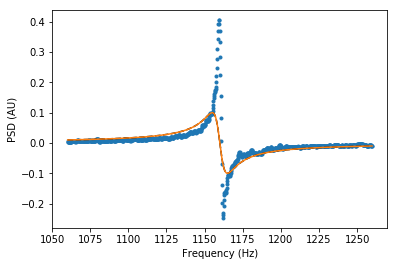

In [183]:
# manually set p0 for first fit

hhdatas[0].p0 = fano_params
hhdatas[0].p0.f0 = 1160
hhdatas[0].p0.bg0 = -0.1

hhdatas[0].fit(do_plot=True)

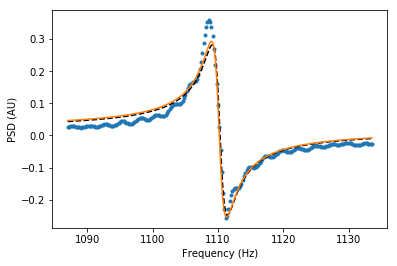

In [184]:
hhdatas[300].plot()

In [101]:
hhdatas.fit_all(do_plot=False)

/home/callum/code/fitit/fitit.py:182: RuntimeWarning: invalid value encountered in sqrt
  errs = pcov.diagonal()**0.5


Warning, optimal parameters not found: Number of calls to function has reached maxfev = 1000.
could not determine fit errors:
Number of calls to function has reached maxfev = 1000.
Warning, optimal parameters not found: Number of calls to function has reached maxfev = 1000.
could not determine fit errors:
Number of calls to function has reached maxfev = 1000.
Warning, optimal parameters not found: Number of calls to function has reached maxfev = 1000.
could not determine fit errors:
Number of calls to function has reached maxfev = 1000.
Warning, optimal parameters not found: Number of calls to function has reached maxfev = 1000.
could not determine fit errors:
Number of calls to function has reached maxfev = 1000.
Warning, optimal parameters not found: Number of calls to function has reached maxfev = 1000.
could not determine fit errors:
Number of calls to function has reached maxfev = 1000.
Warning, optimal parameters not found: Number of calls to function has reached maxfev = 1000.
c

(0, 500)

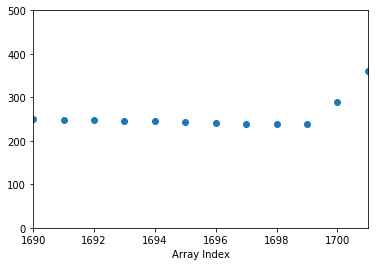

In [147]:
f0s = array([d.popt.f0 for d in hhdatas])
ids = arange(len(hhdatas))


figure()

plot(ids, f0s, 'o')
xlabel("Array Index")
ylabel("")
xlim(1690, 1701)
ylim(0, 500)

changed too quickly!
[0.48384785 0.00217454]
changed too quickly!
[6.06900927e-01 1.45604736e-04]
changed too quickly!
[0.65730631 0.00091952]
changed too quickly!
[9.99270282e-01 1.08053778e-04]
changed too quickly!
[10.0999722   0.02760507]
changed too quickly!
[16.26714058  0.05317935]
changed too quickly!
[2.30390717 0.00364113]
changed too quickly!
[0.6419508  0.00148591]
changed too quickly!
[0.57697114 0.00100928]
changed too quickly!
[6.39807748e-01 2.51088313e-04]
changed too quickly!
[1.161481   0.01168876]
changed too quickly!
[0.71665343 0.0012414 ]


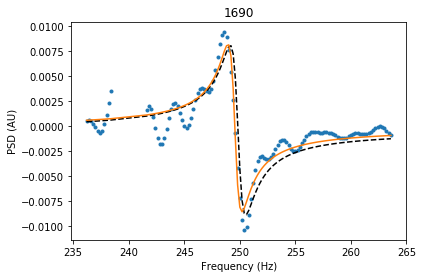

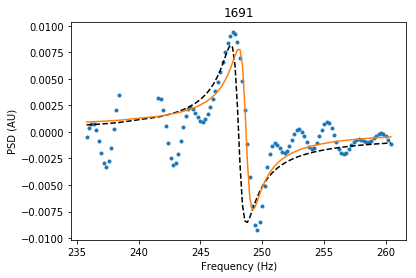

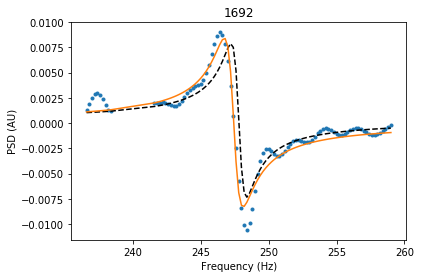

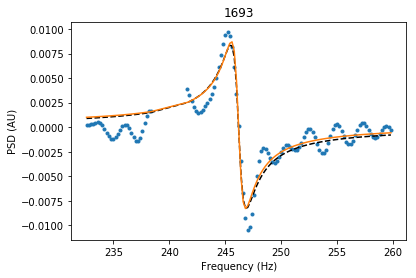

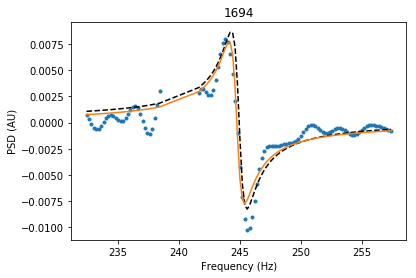

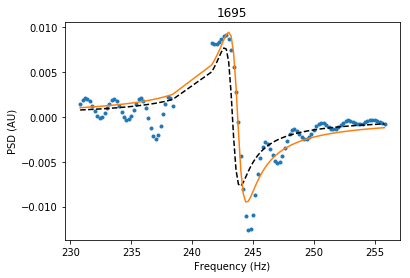

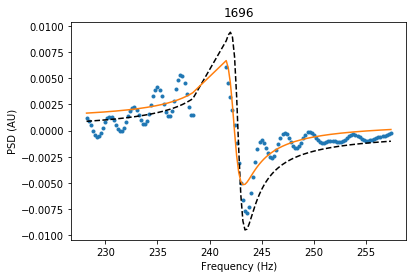

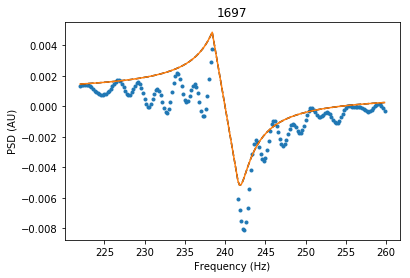

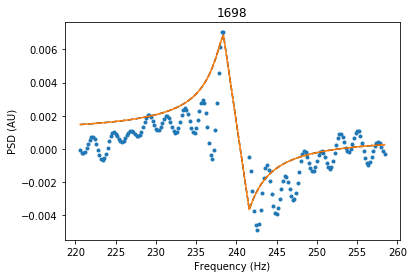

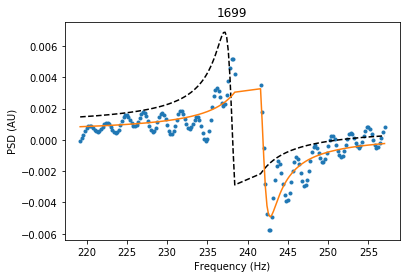

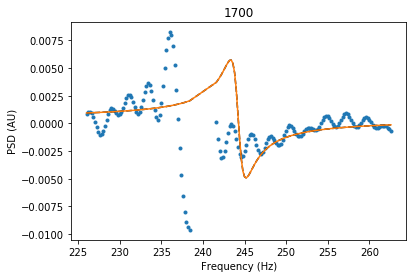

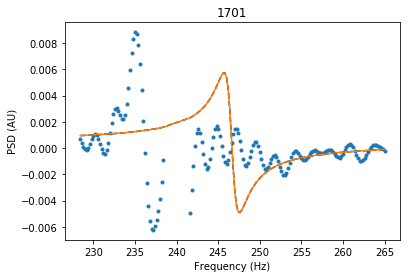

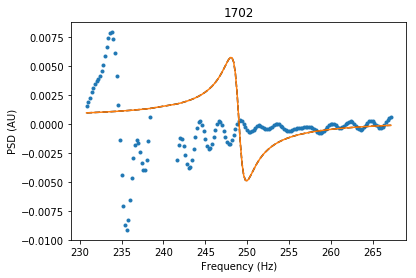

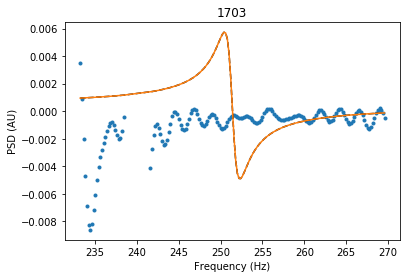

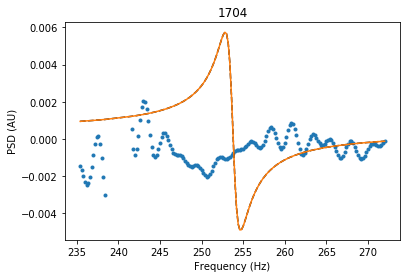

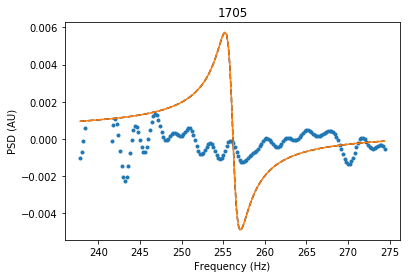

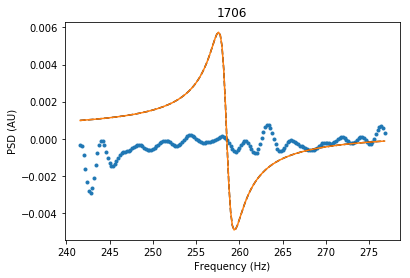

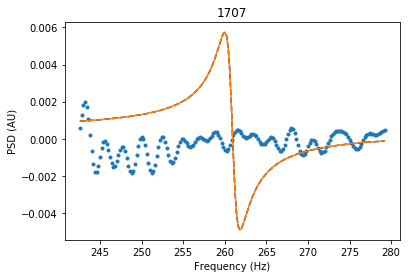

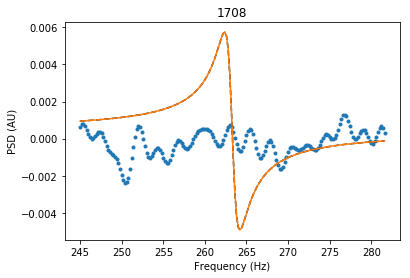

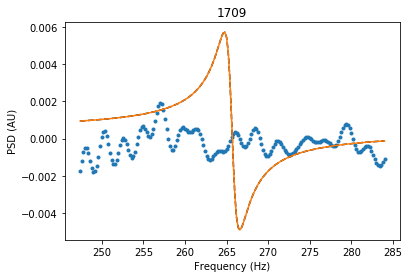

In [187]:
for i in range(1690, 1710):
    hhdatas[i].p0 = hhdatas[i].guess_p0()
    hhdatas[i].fit(do_plot=True)
    title(i)

   bg0: -0.00891063
   bg1: 0
     A: 0.00850389
    f0: 249.833
 gamma: 1.38308
  fano: 1

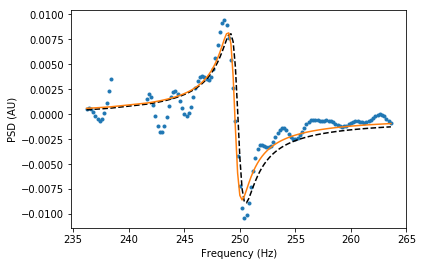

In [177]:
N = 1690

hhdatas[N].plot(filt=1)
hhdatas[N].guess_p0()

(0, 10)

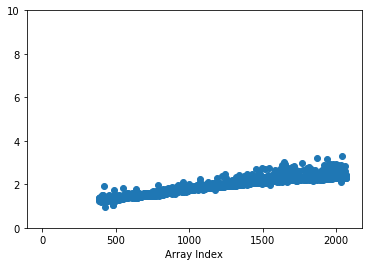

In [103]:
f0s = array([d.popt.f0 for d in hhdatas])
ids = array([d.iden for d in hhdatas])
df = array([abs(d.popt.gamma)for d in hhdatas])


figure()

plot(ids, df, 'o')

xlabel("Array Index")
ylabel("")
# xlim(1500, 2000)
ylim(0, 10)

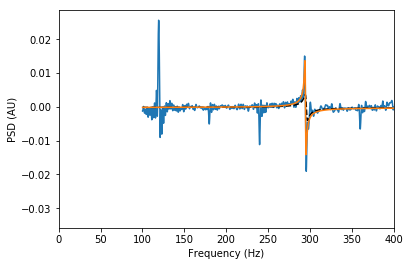

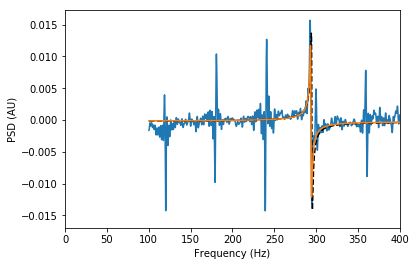

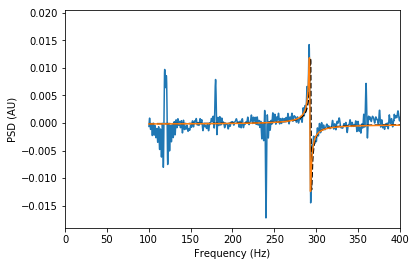

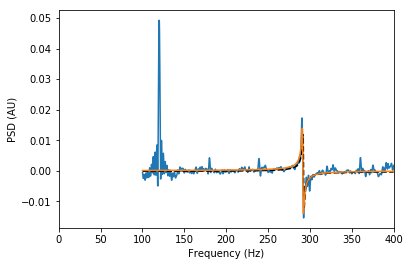

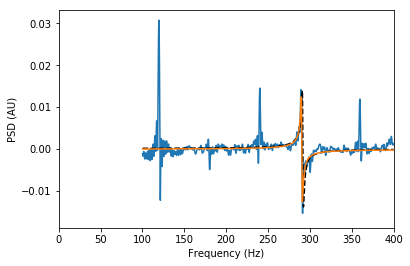

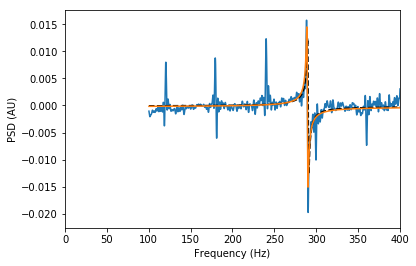

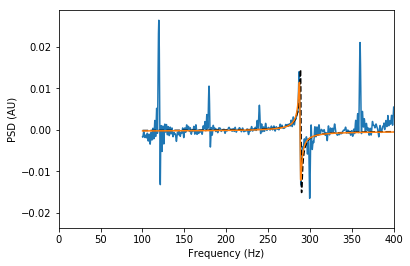

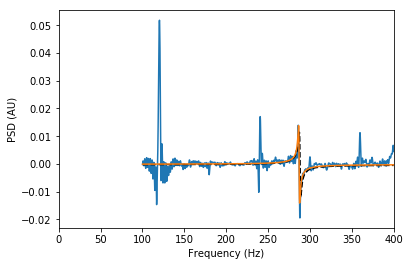

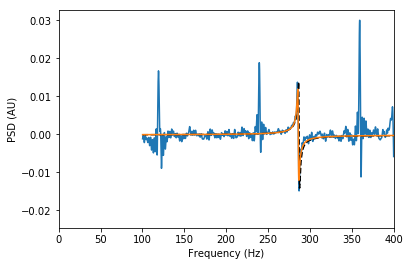

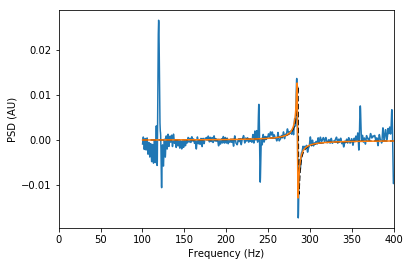

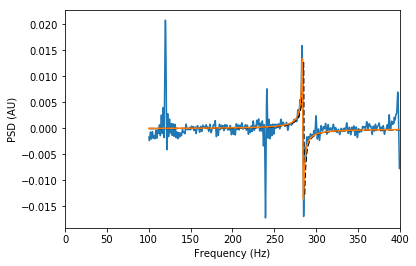

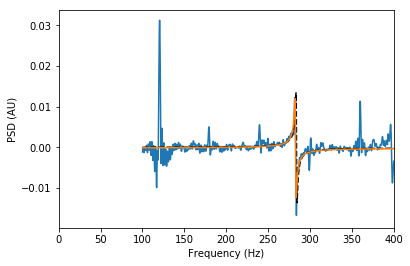

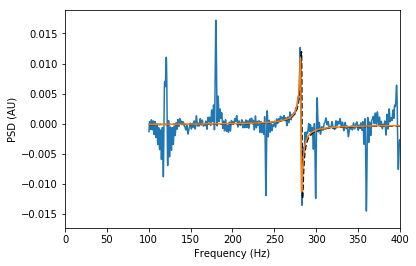

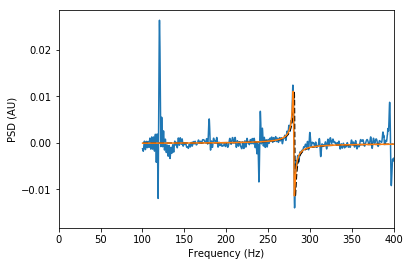

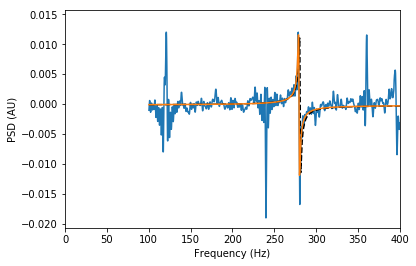

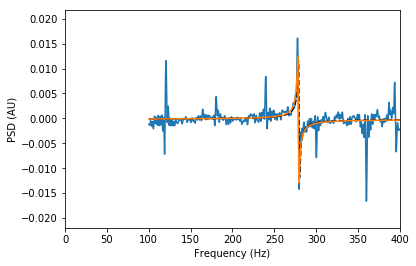

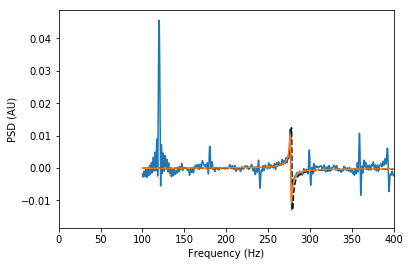

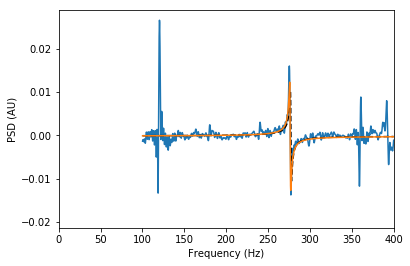

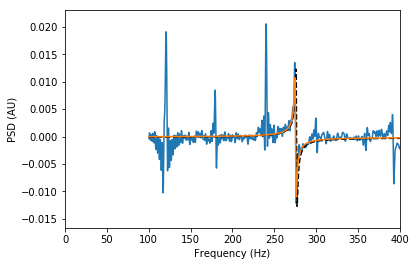

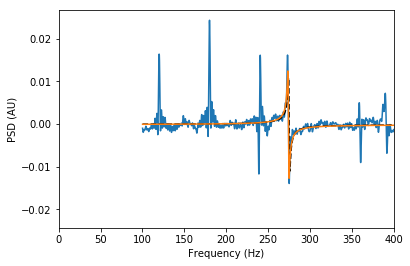

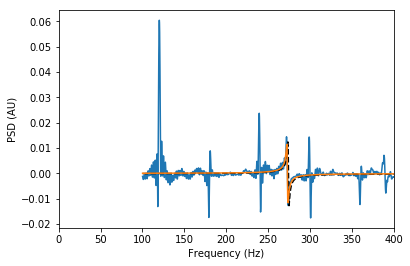

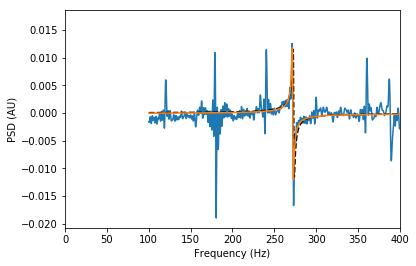

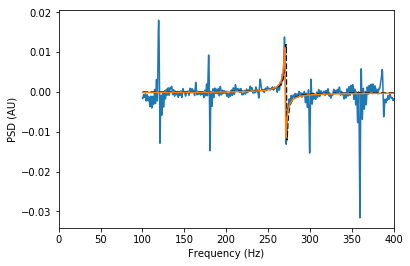

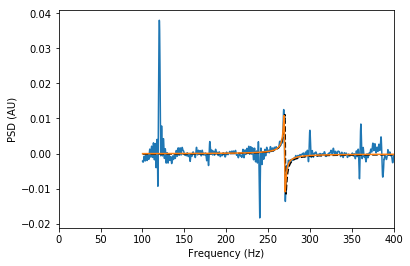

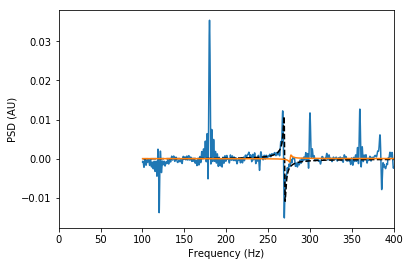

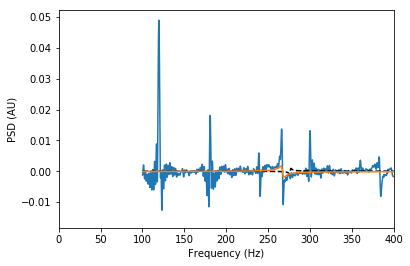

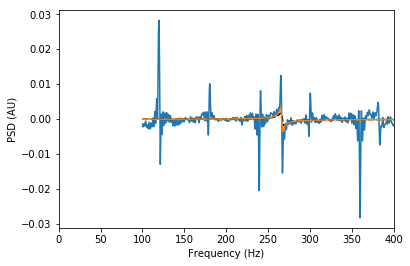

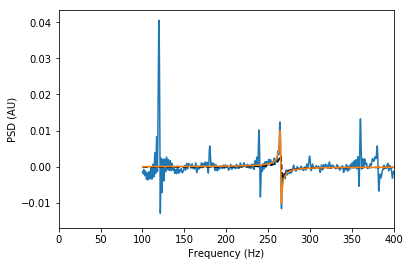

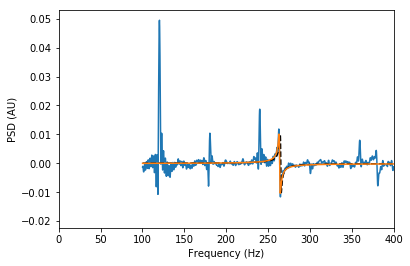

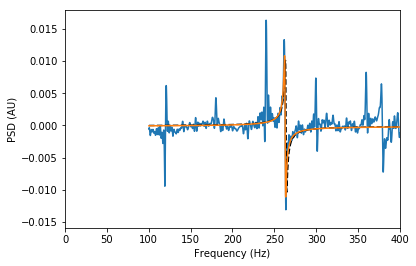

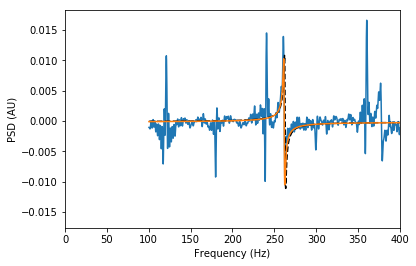

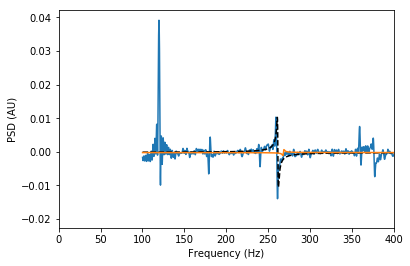

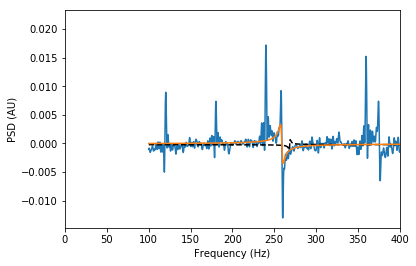

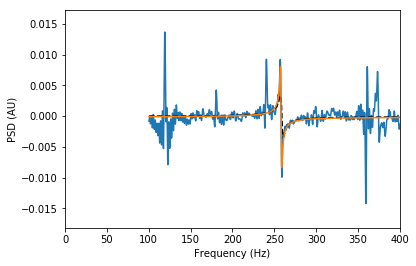

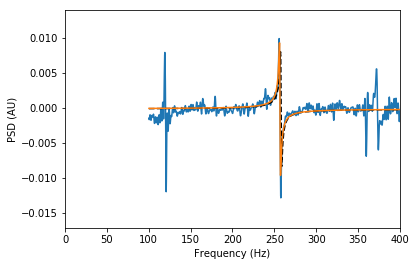

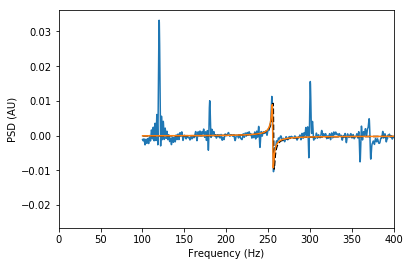

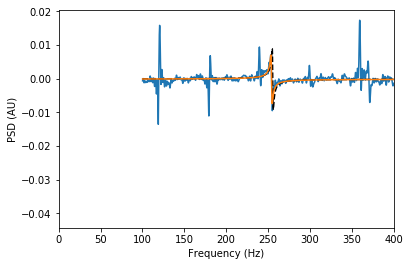

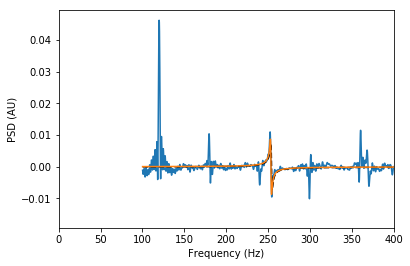

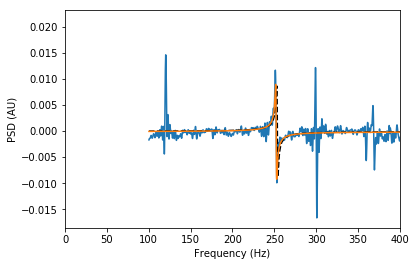

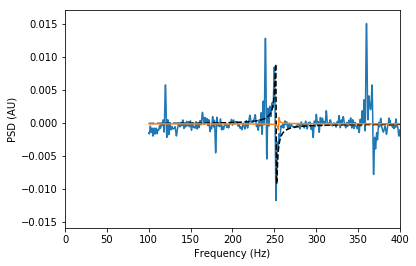

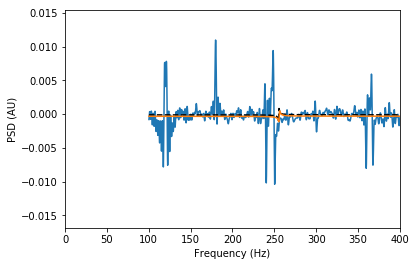

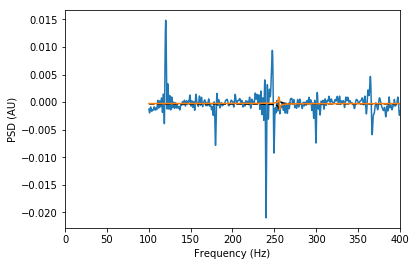

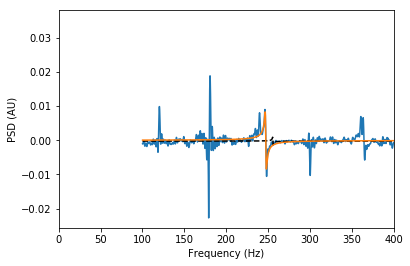

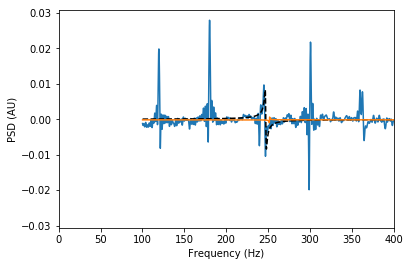

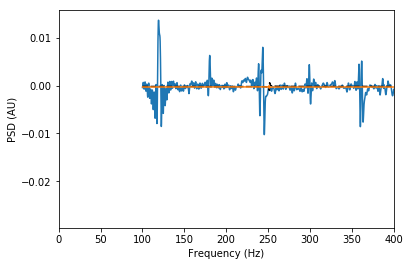

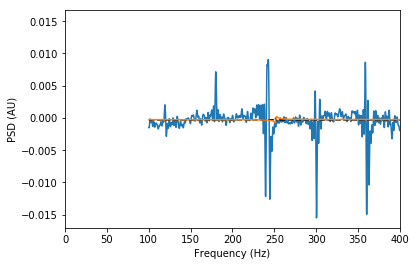

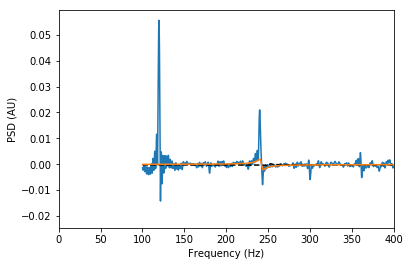

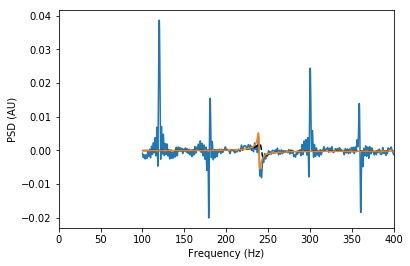

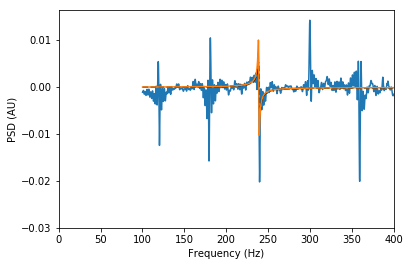

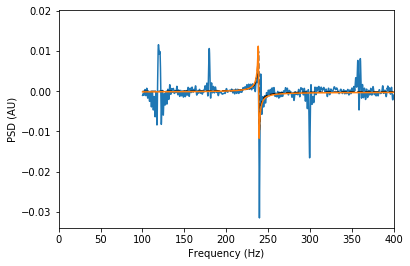

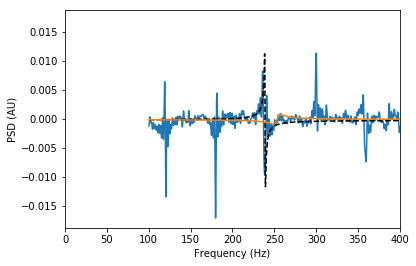

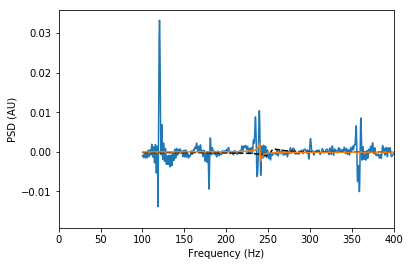

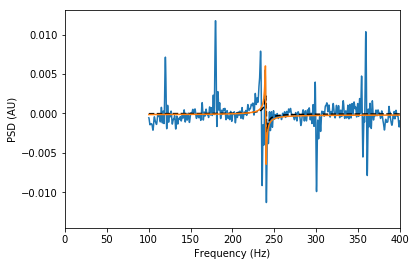

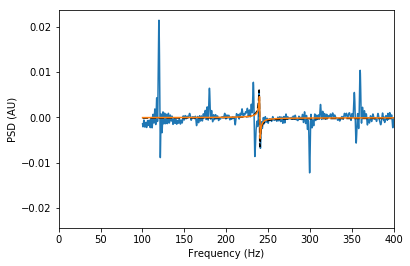

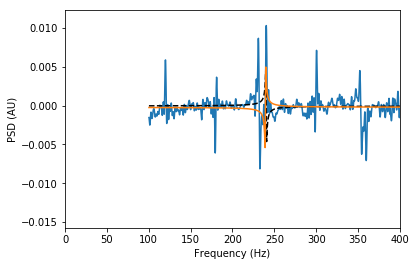

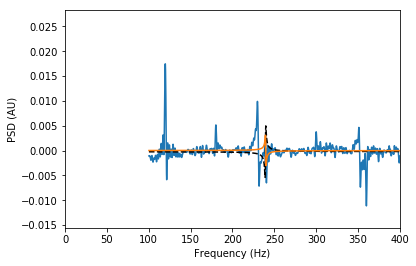

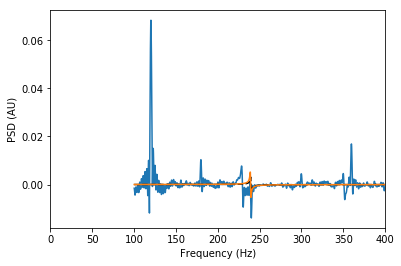

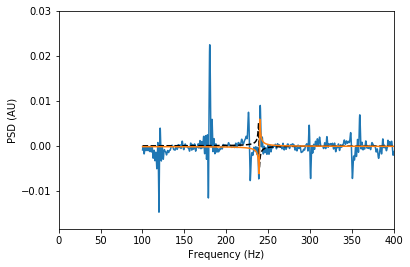

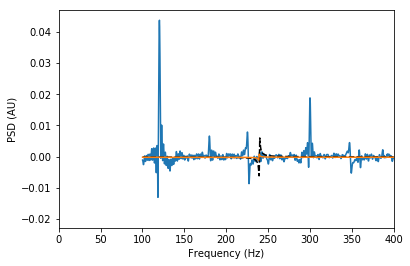

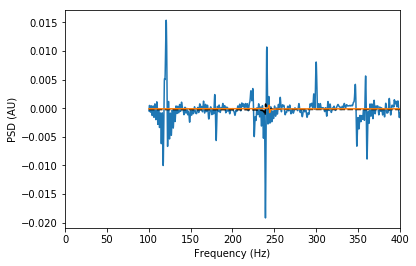

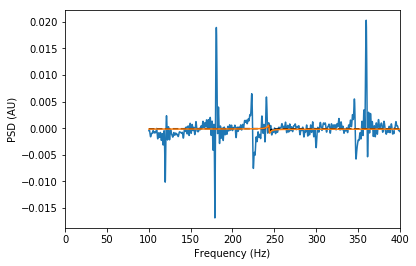

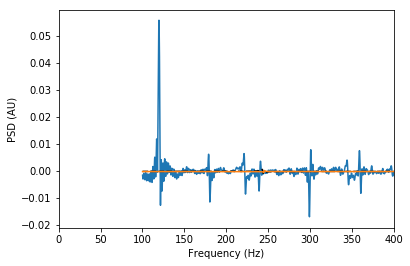

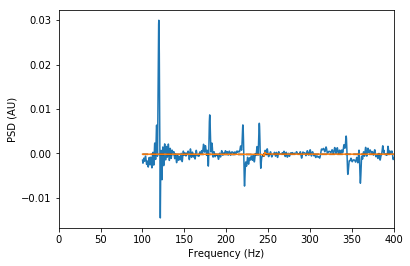

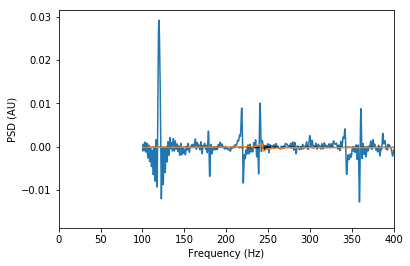

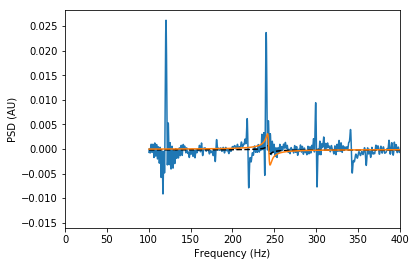

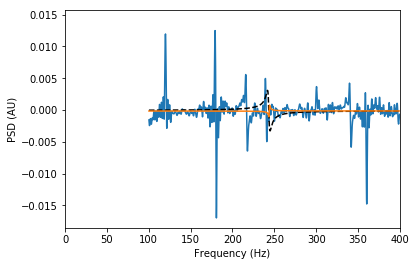

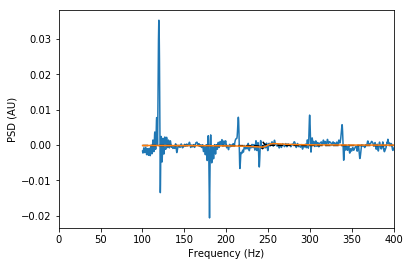

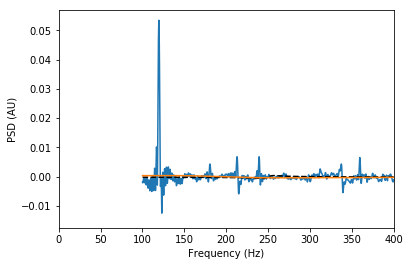

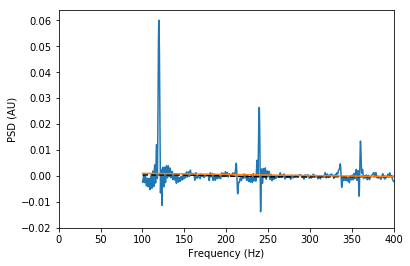

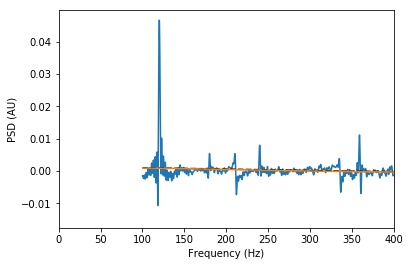

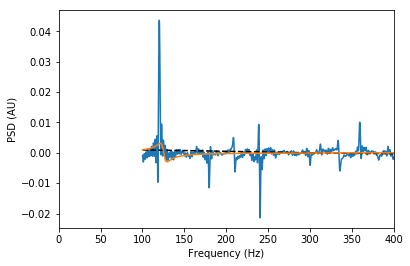

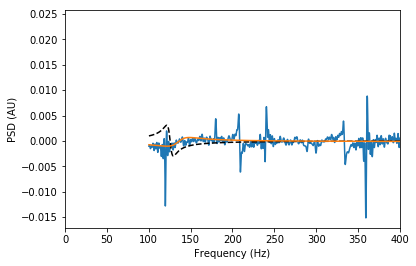

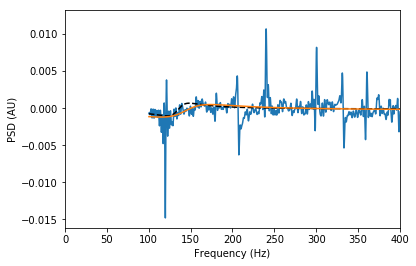

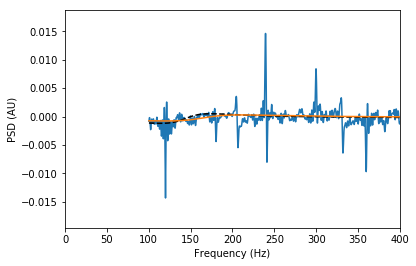

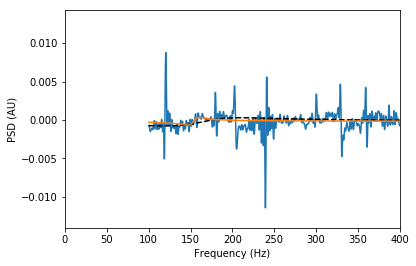

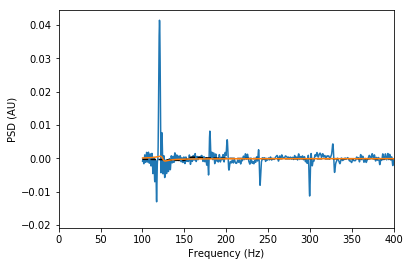

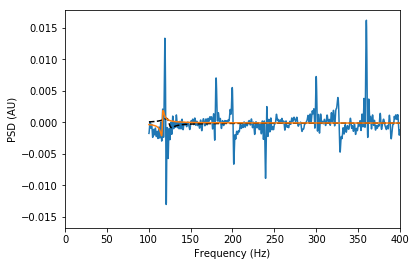

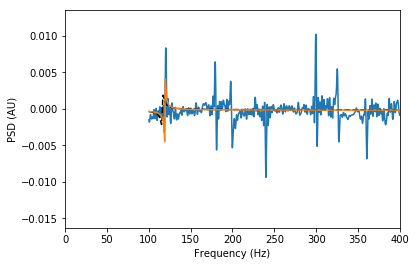

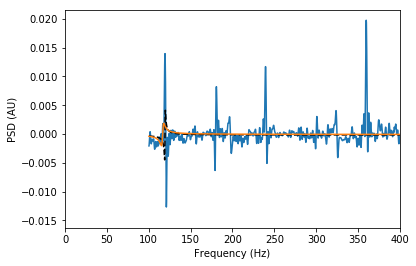

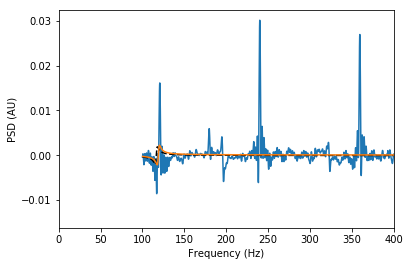

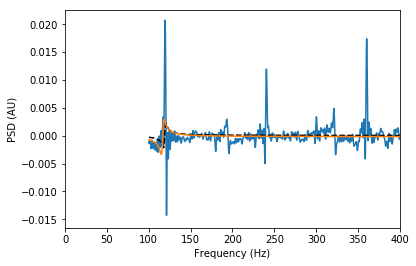

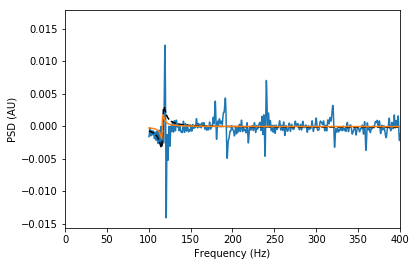

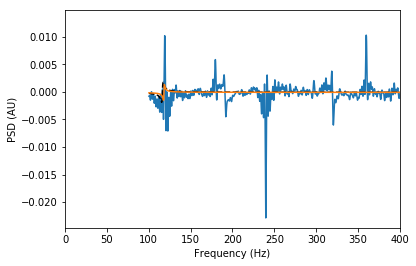

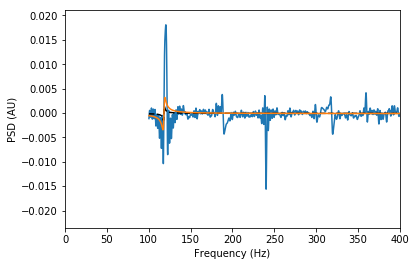

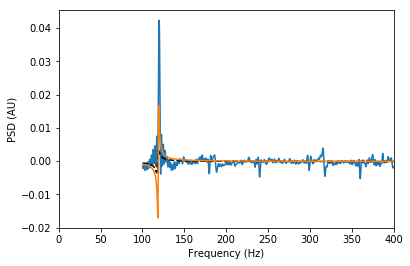

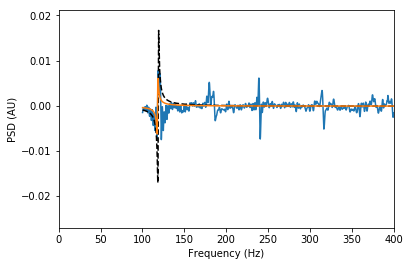

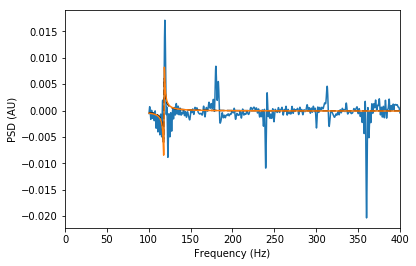

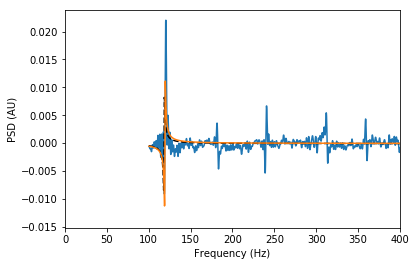

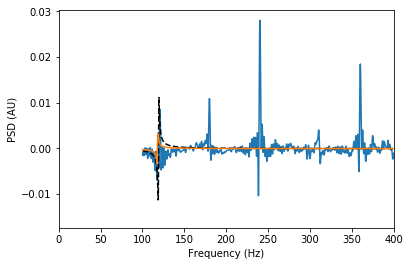

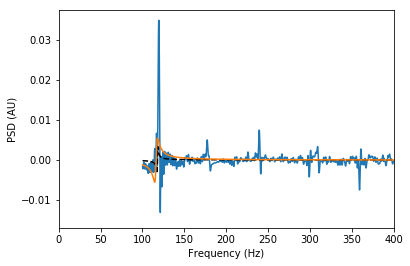

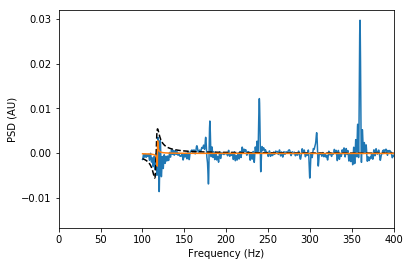

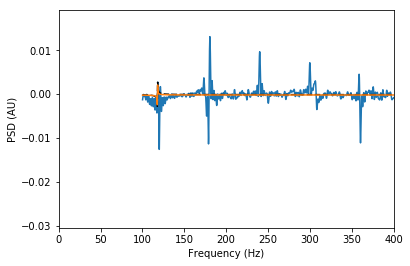

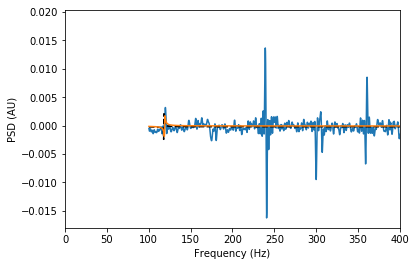

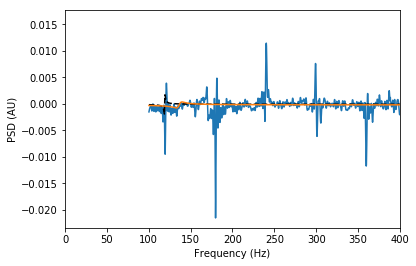

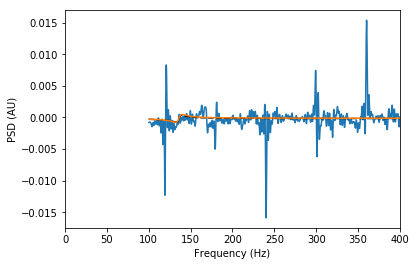

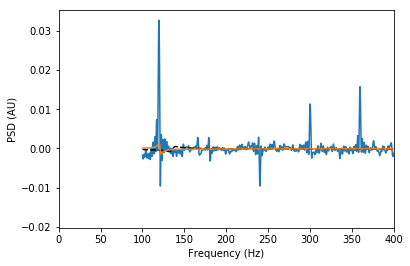

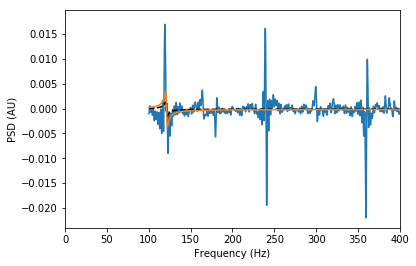

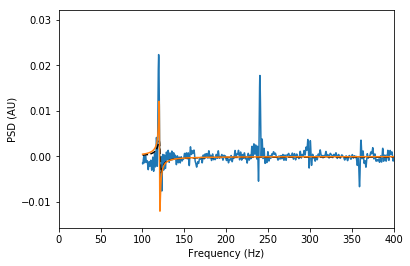

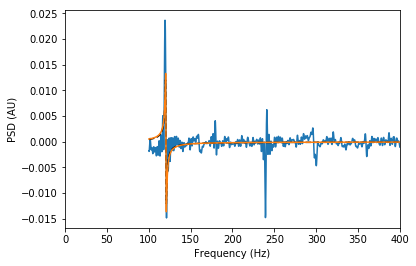

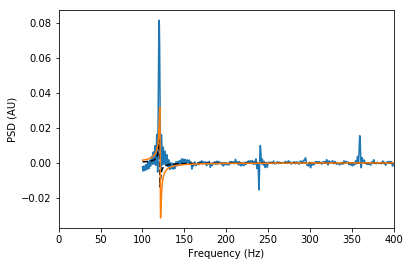

In [12]:
for i in range(1650, 1750):
    hhdatas[i].plot()
    xlim(0, 400)

In [10]:
hhdatas.savebz2("hhdatas.ltdatas.bz2")